# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning

In [5]:
# read csv
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20000.0,20000.0,20000.0,60 months,17.19%,499.10,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,21225.0,21225.0,21225.0,60 months,14.74%,502.05,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000.0,5000.0,5000.0,36 months,17.97%,180.69,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,8.19%,628.49,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,12000.0,12000.0,12000.0,60 months,15.57%,289.09,C,C3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [7]:
print(len(columns))

86


In [8]:
# Load the data
# file_path = Path('LoanStats_2019Q1.csv.zip')
# df = pd.read_csv(file_path, skiprows=1)[:-2]
loans_df = df.loc[:, columns].copy()
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,20000.0,17.19%,499.10,RENT,47000.0,Source Verified,Mar-2019,Issued,n,14.02,...,98.0,12.5,0.0,0.0,75824.0,31546.0,33800.0,21524.0,N,N
1,21225.0,14.74%,502.05,MORTGAGE,225000.0,Not Verified,Mar-2019,Issued,n,16.80,...,100.0,50.0,1.0,0.0,747075.0,209426.0,53500.0,128175.0,N,N
2,5000.0,17.97%,180.69,MORTGAGE,62000.0,Not Verified,Mar-2019,Issued,n,19.82,...,66.7,50.0,0.0,0.0,255738.0,31615.0,9400.0,39938.0,N,N
3,20000.0,8.19%,628.49,MORTGAGE,200000.0,Not Verified,Mar-2019,Issued,n,22.66,...,95.7,22.2,0.0,0.0,448069.0,84744.0,49400.0,105180.0,N,N
4,12000.0,15.57%,289.09,MORTGAGE,49000.0,Source Verified,Mar-2019,Issued,n,13.47,...,86.1,14.3,0.0,0.0,189260.0,106025.0,24400.0,68860.0,N,N


In [9]:
# Drop the null columns where all values are null
loans_df = loans_df.dropna(axis='columns', how='all')
# Drop the null rows
loans_df = loans_df.dropna()
loans_df.head()


,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,20000.0,17.19%,499.10,RENT,47000.0,Source Verified,Mar-2019,Issued,n,14.02,...,98.0,12.5,0.0,0.0,75824.0,31546.0,33800.0,21524.0,N,N
1,21225.0,14.74%,502.05,MORTGAGE,225000.0,Not Verified,Mar-2019,Issued,n,16.80,...,100.0,50.0,1.0,0.0,747075.0,209426.0,53500.0,128175.0,N,N
3,20000.0,8.19%,628.49,MORTGAGE,200000.0,Not Verified,Mar-2019,Issued,n,22.66,...,95.7,22.2,0.0,0.0,448069.0,84744.0,49400.0,105180.0,N,N
4,12000.0,15.57%,289.09,MORTGAGE,49000.0,Source Verified,Mar-2019,Issued,n,13.47,...,86.1,14.3,0.0,0.0,189260.0,106025.0,24400.0,68860.0,N,N
6,25000.0,7.02%,772.16,MORTGAGE,305000.0,Not Verified,Mar-2019,Issued,n,8.16,...,100.0,0.0,0.0,0.0,840287.0,65339.0,81000.0,38858.0,N,N


In [10]:
# Drop the null rows
loans_df = loans_df.dropna()
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82537 entries, 0 to 115673
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   82537 non-null  float64
 1   int_rate                    82537 non-null  object 
 2   installment                 82537 non-null  float64
 3   home_ownership              82537 non-null  object 
 4   annual_inc                  82537 non-null  float64
 5   verification_status         82537 non-null  object 
 6   issue_d                     82537 non-null  object 
 7   loan_status                 82537 non-null  object 
 8   pymnt_plan                  82537 non-null  object 
 9   dti                         82537 non-null  float64
 10  delinq_2yrs                 82537 non-null  float64
 11  inq_last_6mths              82537 non-null  float64
 12  open_acc                    82537 non-null  float64
 13  pub_rec                     82

In [11]:
loans_df['loan_status'].value_counts()

Current               68470
Issued                13720
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [12]:
# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
loans_df = loans_df.loc[issued_mask]
loans_df['loan_status'].value_counts()

Current               68470
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [13]:
# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
loans_df = loans_df.replace(x)
loans_df['loan_status'].value_counts()

low_risk              68470
In Grace Period         171
Late (16-30 days)        89
Late (31-120 days)       87
Name: loan_status, dtype: int64

In [14]:
x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
loans_df = loans_df.replace(x)
loans_df['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [15]:
# # convert interest rate to numerical
loans_df['int_rate'] = loans_df['int_rate'].str.replace('%', '')
loans_df['int_rate'] = loans_df['int_rate'].astype('float') / 100
loans_df.reset_index(inplace=True, drop=True)
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


### Create the training variables by converting the string values into numerical ones using the get_dummies() method.

In [16]:
# what are out catergorical value colums
columns_obj = loans_df.select_dtypes(include= 'object').columns
print(len(columns_obj))

10


In [17]:
# get_dummies method in pandas 
columns_obj

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

In [18]:
# examine home ownership
loans_df["home_ownership"].value_counts()

MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64

In [19]:
loans_df.shape

(68817, 86)

In [20]:
# drop columns that have just one value in value_counts()
loans_df = loans_df.drop(columns=['debt_settlement_flag', 'hardship_flag', 'pymnt_plan'])
loans_df.shape

(68817, 83)

In [21]:
loans_df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [22]:
# save loans as clean csv file
clean_loans_df = loans_df
clean_loans_df.to_csv("clean_loans.cvs",index=False)

In [23]:
df = pd.read_csv("clean_loans.cvs")
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


# Split the Data into Training and Testing

In [24]:
# Create our features
X = df.drop(columns='loan_status')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 82 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   dti                         68817 non-null  float64
 8   delinq_2yrs                 68817 non-null  float64
 9   inq_last_6mths              68817 non-null  float64
 10  open_acc                    68817 non-null  float64
 11  pub_rec                     68817 non-null  float64
 12  revol_bal                   68817 non-null  float64
 13  total_acc                   688

In [25]:
# Create our target
y = df['loan_status']
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [26]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [27]:
# get_dummies to transform object dtypes 
X_encoded = pd.get_dummies(X)
X_encoded.shape

(68817, 92)

In [28]:
# all columns in feature matrix
X_encoded.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.148001,0.371696,0.451066,0.177238,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.355104,0.483261,0.497603,0.381873,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
# Check the balance of our target values
y.shape


(68817,)

### standard scale X_encoded feature matrix

In [30]:
# scale the x_encoded feature matric 
data_scaler = StandardScaler()

In [31]:
# fit and tranform our X_encoded
X_encoded_scaled = data_scaler.fit_transform(X_encoded)
X_encoded_scaled[:1]

array([[-0.60109272,  0.91798436, -0.36555835, -0.1921948 ,  0.27040056,
        -0.30314253, -0.65649151, -0.76165917, -0.37420432, -0.73252183,
        -0.8658573 , -0.58124513, -0.58081958, -0.50046544, -0.50029335,
        -0.3228639 , -0.89960419, -0.03227363,  0.        ,  0.        ,
        -0.17383528, -0.12011247,  0.        ,  0.        , -0.00589695,
        -0.72692228,  1.67997825,  0.2392533 ,  1.19137226,  1.35299632,
        -0.80895603, -0.13418715, -0.45717571, -0.16310175, -0.24864022,
        -0.83203994,  0.12422197, -1.04213361, -0.24758239, -0.59166015,
         0.75578041,  0.37274923, -0.59052419, -0.80915288,  1.04494582,
        -0.07820908, -0.00778953, -0.56994022, -0.7981628 , -0.64845959,
        -0.66313947, -0.8249868 , -0.14674317, -1.10824038, -0.33490355,
        -1.13862411, -1.05103022, -1.27998521, -1.40011594,  0.06599699,
        -1.11347944, -1.31043257, -1.0519437 , -0.75930693,  0.        ,
         0.        , -0.13347217,  0.41138923, -1.1

In [32]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, random_state =1)


In [33]:
y_train.value_counts()

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64

In [34]:
print(246/51366)

0.004789160144842892


In [35]:
#Use the LogisticRegression classifier to make predictions and evaluate the model’s performance.
#Calculate the accuracy score of the model.
#Generate a confusion matrix.
#Print out the imbalanced classification report.
#classification report .ing logistics regression
# imballanced classification report .ing logistics regression


In [36]:
# Instantiate a Logistic Regression Model 
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [37]:
# fit our model with out data(taining)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [38]:
# create predications using predict() method
y_pred = classifier.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [39]:
# calculate model accuracy 
accuracy_score(y_test, y_pred)

0.995059575704737

In [40]:
# create confusion matrix 
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[   21    80]
 [    5 17099]]


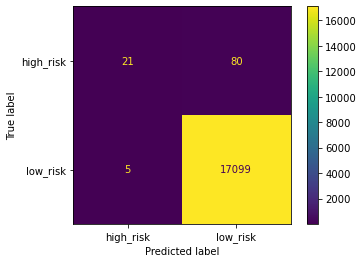

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels= classifier.classes_)
disp.plot()

In [42]:
# view the classification report 
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.81      0.21      0.33       101
    low_risk       1.00      1.00      1.00     17104

    accuracy                           1.00     17205
   macro avg       0.90      0.60      0.66     17205
weighted avg       0.99      1.00      0.99     17205



In [43]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.81      0.21      1.00      0.33      0.46      0.19       101
   low_risk       1.00      1.00      0.21      1.00      0.46      0.22     17104

avg / total       0.99      1.00      0.21      0.99      0.46      0.22     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [44]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [45]:
# ehat is the "balance " or mix between loan_status
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [46]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

In [47]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8324883762931952

In [48]:
# Display the confusion matrix
model = confusion_matrix(y_test, y_pred, labels =classifier.classes_)

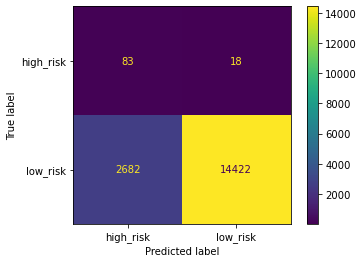

In [49]:
disp = ConfusionMatrixDisplay(confusion_matrix=model, display_labels=classifier.classes_)
disp.plot()


# save image
plt.savefig("images/Oversampler_matrix.png")

In [50]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.84      0.06      0.83      0.69       101
   low_risk       1.00      0.84      0.82      0.91      0.83      0.69     17104

avg / total       0.99      0.84      0.82      0.91      0.83      0.69     17205



### SMOTE Oversampling

In [51]:
# Resample the training data with SMOTE

X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

In [52]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



In [53]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8440938486973113

In [54]:
# Display the confusion matrix
model = confusion_matrix(y_test, y_pred, labels=model.classes_)
print(model)

[[   83    18]
 [ 2285 14819]]


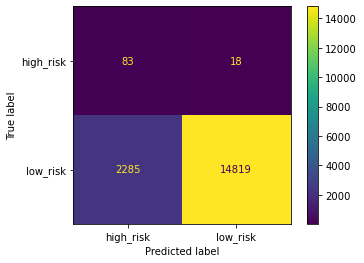

In [55]:
disp = ConfusionMatrixDisplay(confusion_matrix=model, display_labels=classifier.classes_)
disp.plot()


# save image
plt.savefig("images/SMOTE_matrix.png")

In [56]:
# Print the imbalanced classification report

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [57]:
# Resample the data using the ClusterCentroids resampler
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [58]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [59]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8440938486973113

In [60]:
# Display the confusion matrix
model = confusion_matrix(y_test, y_pred, labels=model.classes_)
print(model)

[[   83    18]
 [ 2285 14819]]


In [61]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



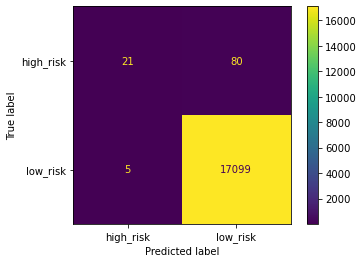

In [62]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels= classifier.classes_)
disp.plot()


# save image
plt.savefig("images/Cluster_confusion_matrix.png")

# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [63]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = SMOTEENN(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 51366, 'low_risk': 47640})

In [68]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

In [69]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.8389196204466096

In [70]:
# Display the confusion matrix
model = confusion_matrix(y_test, y_pred, labels=model.classes_)
print(model)

[[   83    18]
 [ 2462 14642]]


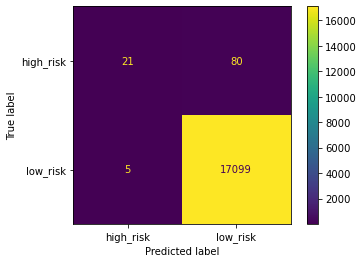

In [71]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels= classifier.classes_)
disp.plot()


# save image
plt.savefig("images/SMOOTEEN_matrix.png")

In [72]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.86      0.06      0.84      0.70       101
   low_risk       1.00      0.86      0.82      0.92      0.84      0.71     17104

avg / total       0.99      0.86      0.82      0.92      0.84      0.71     17205

